https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

In [1]:
import os

os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [2]:
import pandas as pd
# import cartopy.crs as ccrs
# import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import numpy as np

In [3]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'

dfTotalCount = pd.read_csv(url)

In [4]:
countryLabel = 'Netherlands'

country = dfTotalCount[dfTotalCount['Country/Region']==countryLabel]
subset = country.drop(['Province/State', 'Country/Region', 'Lat', 'Long'], axis=1)
# pd.DataFrame(data=df[df['Country/Region']=='Poland'],)

In [5]:
print(subset.values[0])
subset.columns
# print(subset.)

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   1   1   6  10  18  24  38  82 128]


Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/2/20',
       '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20',
       '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20',
       '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/20/20', '2/21/20',
       '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20',
       '2/28/20', '2/29/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20',
       '3/6/20'],
      dtype='object')

In [6]:
reports = pd.DataFrame(data=subset.transpose(),index = subset.columns)

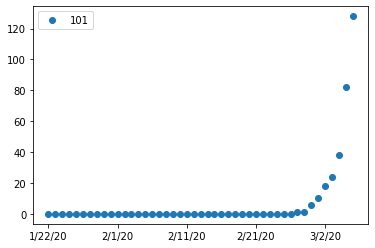

In [11]:
reports.plot(style='o')

In [8]:
x_train = np.linspace(0,subset.values[0].shape[0]-1,subset.values[0].shape[0]).reshape(-1, 1)
y_train = subset.values[0].reshape(-1, 1)

x_pred = np.linspace(0,99,100).reshape(-1, 1)

## Scikit - Learn

In [141]:
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, DotProduct, Exponentiation

# y_pred, sigma = gp.predict(x_pred, return_std=True)
# kernel = ConstantKernel() + Matern(length_scale=2, nu=3/2) + WhiteKernel(noise_level=1) + DotProduct()
kernel = ConstantKernel(1.0) * Matern(length_scale=2, nu=3/2)#+ Exponentiation(DotProduct(),3)# + Exponentiation()
kernel = ConstantKernel(.001)* (DotProduct(sigma_0=1) ** 2)

# gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
# gp.fit(x_train, y_train)

gp = gaussian_process.GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
kernel=kernel,
n_restarts_optimizer=0, normalize_y=False,
optimizer='fmin_l_bfgs_b', random_state=None)
# gp.fit(x_train, y_train)

y_pred, sigma = gp.predict(x_pred, return_std=True)

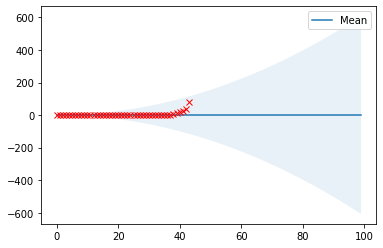

In [143]:
plot_gp(y_pred, np.diag(sigma**2), x_pred, X_train=x_train, Y_train=y_train)

## GPFlow approach

In [74]:
import gpflow
import tensorflow as tf
import numpy as np
import matplotlib
from gpflow.utilities import print_summary, set_trainable, to_default_float
import tensorflow_probability as tfp

In [110]:
X = np.linspace(-3,3,20)
# Y = np.asarray(np.random.poisson(np.sin(X*10)**2),dtype=np.double)
Y = np.random.poisson(np.sin(X*10)**2).astype(float)
k = gpflow.kernels.Matern32(1) + gpflow.kernels.Bias(1)
l = gpflow.likelihoods.Poisson()
m = gpflow.models.GPMC(data=(X[:,None], Y[:,None]), kernel=k, likelihood=l)
m.kernel.kernels[0].variance.prior = tfp.distributions.Gamma(
    to_default_float(1), to_default_float(1))
m.kernel.kernels[0].lengthscale.prior = tfp.distributions.Gamma(
    to_default_float(1), to_default_float(1))
m.kernel.kernels[1].variance.prior = tfp.distributions.Gamma(
    to_default_float(1), to_default_float(1))
# m.kernel.kernels[0].lengthscale.assign(1.) #gpflow.priors.Gamma(1., 1.)
# m.kernel.kernels[0].variance.assign(1.) #gpflow.priors.Gamma(1.,1.)
# m.kernel.kernels[1].variance.assign(1.) #gpflow.priors.Gamma(1.,1.)

opt = gpflow.optimizers.Scipy()

# @tf.function(autograph=False)
def objective_closure():
    return - m.log_marginal_likelihood()

opt_logs = opt.minimize(objective_closure,m.trainable_variables,options=dict(maxiter=15))
        
print_summary(m, fmt='notebook')
# m.optimize(maxiter=15) # start near MAP
# samples = m.sample(500, verbose=True, epsilon=0.12, Lmax=15)

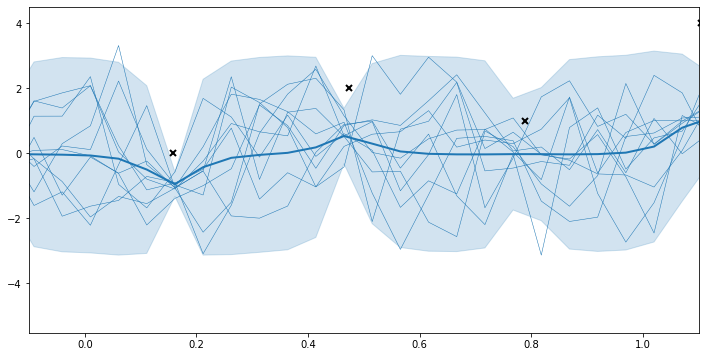

In [111]:
## generate test points for prediction
xx = np.linspace(-1, 4, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = m.predict_f(xx)

## generate 10 samples from posterior
samples = m.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'kx', mew=2)
plt.plot(xx, mean, 'C0', lw=2)
plt.fill_between(xx[:,0],
                 mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                 mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                 color='C0', alpha=0.2)

plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
plt.xlim(-0.1, 1.1);

In [19]:
m.kernel.kernels[0]

name                  class      transform    prior    trainable    shape    dtype              value
--------------------  ---------  -----------  -------  -----------  -------  -------  ---------------
Matern32.variance     Parameter  Softplus              True         ()       float64  1131.84
Matern32.lengthscale  Parameter  Softplus              True         ()       float64     2.12222e-144

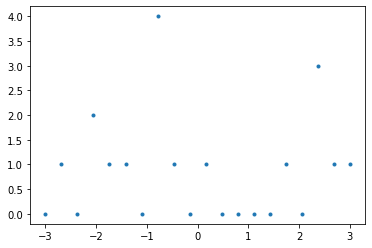

In [21]:
plt.plot(X,Y,'.')

## Numpy approach 

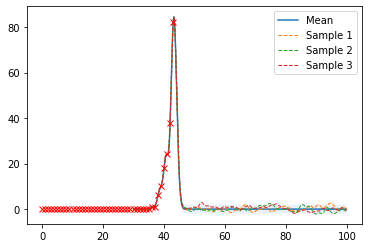

In [60]:
# from gaussian_processes_util import plot_gp

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

def plot_gp_2D(gx, gy, mu, X_train, Y_train, title, i):
    ax = plt.gcf().add_subplot(1, 2, i, projection='3d')
    ax.plot_surface(gx, gy, mu.reshape(gx.shape), cmap=cm.coolwarm, linewidth=0, alpha=0.2, antialiased=False)
    ax.scatter(X_train[:,0], X_train[:,1], Y_train, c=Y_train, cmap=cm.coolwarm)
    ax.set_title(title)


# # Finite number of points
# X = np.arange(30, 100, 0.2).reshape(-1, 1)

# # Mean and covariance of the prior
# mu = np.zeros(X.shape)
# cov = kernel(X, X)

# # Draw three samples from the prior
# samples = np.random.multivariate_normal(mu.ravel(), cov, 3)

# # Plot GP mean, confidence interval and samples 
# plot_gp(mu, cov, X, samples=samples)

from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s
    
    
# Noise free training data
# X_train = np.array([-4, -3, -2, -1, 1]).reshape(-1, 1)
# Y_train = np.sin(X_train)
X_train = np.linspace(0,subset.values[0].shape[0]-1,subset.values[0].shape[0]).reshape(-1, 1)
Y_train = subset.values[0].reshape(-1, 1)

# Compute mean and covariance of the posterior predictive distribution
mu_s, cov_s = posterior_predictive(X, X_train, Y_train)

samples = np.random.multivariate_normal(mu_s.ravel(), cov_s, 3)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train, samples=samples)    

In [98]:
cov_s.shape

(350, 350)

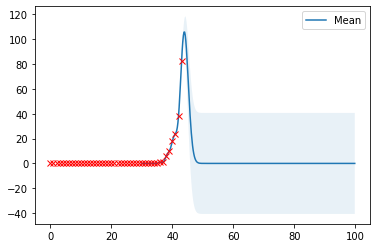

In [62]:
from numpy.linalg import cholesky
from scipy.optimize import minimize


noise = 0.01

def nll_fn(X_train, Y_train, noise):
    '''
    Returns a function that computes the negative log-likelihood
    for training data X_train and Y_train and given noise level.
    
    Args:
        X_train: training locations (m x d).
        Y_train: training targets (m x 1).
        noise: known noise level of Y_train.
        
    Returns:
        Minimization objective.
    '''
    def step(theta):
        K = kernel(X_train, X_train, l=theta[0], sigma_f=theta[1]) + \
            noise**2 * np.eye(len(X_train))
        # Compute determinant via Cholesky decomposition
        return np.sum(np.log(np.diagonal(cholesky(K)))) + \
               0.5 * Y_train.T.dot(inv(K).dot(Y_train)) + \
               0.5 * len(X_train) * np.log(2*np.pi)
    return step

# Minimize the negative log-likelihood w.r.t. parameters l and sigma_f.
# We should actually run the minimization several times with different
# initializations to avoid local minima but this is skipped here for
# simplicity.
res = minimize(nll_fn(X_train, Y_train, noise), [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B',)

# Store the optimization results in global variables so that we can
# compare it later with the results from other implementations.
l_opt, sigma_f_opt = res.x
l_opt, sigma_f_opt

# Compute the prosterior predictive statistics with optimized kernel parameters and plot the results
mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l_opt, sigma_f=sigma_f_opt, sigma_y=noise)
plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

In [53]:
np.linspace(0,subset.values[0].shape[0]-1,subset.values[0].shape[0])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43.])

----

## 2D input

In [205]:
import os.path
from os import path

date = '06032020' # started from 03032020
vgzfile = 'klik_corona' + date + '.csv'
vgzurl = 'https://www.volksgezondheidenzorg.info/sites/default/files/map/detail_data/' + vgzfile
if not path.exists('data/' +vgzfile):
    !wget $vgzurl -P data/

In [206]:
!ls

Pipfile                  dfm                      lawOfLargeNumbers.ipynb
Pipfile.lock             figures                  pytorch_regression.ipynb
corona.ipynb             fonnesbeck
data                     klik_corona03032020.csv


In [207]:
df_NL = pd.read_csv('data/'+vgzfile,delimiter=';')
df_NL['Aantal'].sum()

126.0

In [208]:
df_NL['Aantal'].sum()

126.0

In [209]:
gemeenten = pd.read_csv('data/gemeenten.csv')
gemeenten = gemeenten.rename(columns={"NAAM": "Gemeente"})

In [213]:
dfNL = df_NL.merge(gemeenten,on='Gemeente')
dfNL = dfNL.fillna(0)

In [214]:
## Create map

In [215]:
#BBox = (gemeenten.Lon.min(), gemeenten.Lon.max(), gemeenten.Lat.min(), gemeenten.Lat.max())

In [216]:
BBox=((3.0006408691406254,7.325906753540039,50.69414695350509,53.79928213877752))

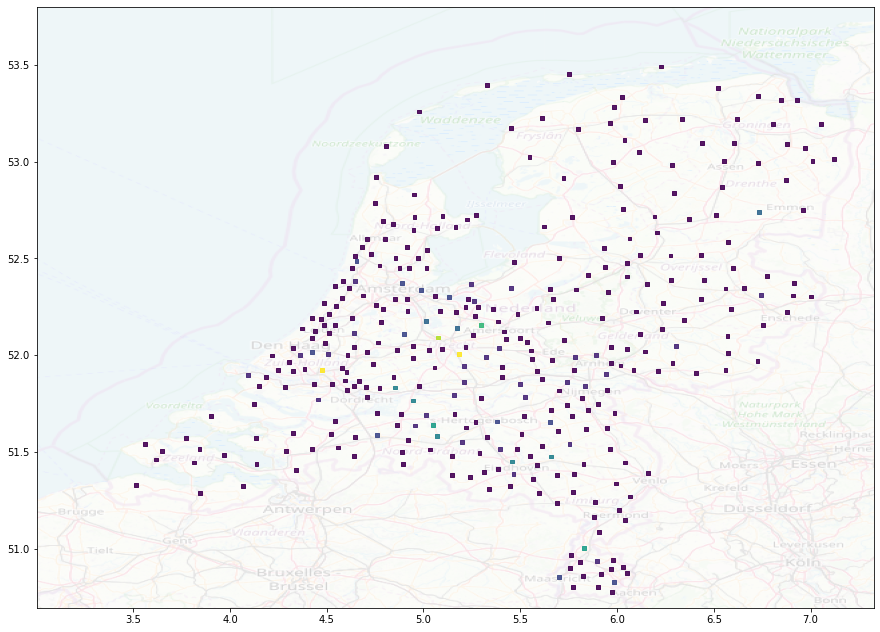

In [217]:
fig, ax = plt.subplots(figsize = (15,15))

ax.scatter(dfNL.Lon, dfNL.Lat, zorder=1, alpha= 0.9, c=dfNL.Aantal, s=15, marker='s',cmap=plt.cm.viridis)
# ax.set_title('Plotting Spatial Data on Riyadh Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
nlMap = plt.imread('figures/mapNetherlands.png')
ax.imshow(nlMap, zorder=0, extent = BBox, aspect= 'equal',alpha=.2)
# plt.colormap()
# plt.axes('equal')

In [218]:
X_obs = dfNL[['Lon', 'Lat']].values
y_obs = dfNL['Aantal'].values

In [219]:
# %matplotlib inline
# import numpy as np
# import pandas as pd
import pymc3 as pm
# import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

In [24]:
nd = 15
xu1, xu2 = np.meshgrid(np.linspace(BBox[0], BBox[1], nd), np.linspace(BBox[2], BBox[3], nd))
Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1)

In [26]:
with pm.Model() as spatial_model:
    
    l = pm.HalfCauchy("l", shape=(2,))
    sf2 = pm.HalfCauchy("sf2")
    sn2 = pm.HalfCauchy("sn2")

    K = pm.gp.cov.ExpQuad(2, l) * sf2**2
    
    gp_spatial = pm.gp.MarginalSparse(cov_func=K, approx="FITC")
    obs = gp_spatial.marginal_likelihood("obs", X=X_obs, Xu=Xu, y=y_obs, noise=1e-2)

    mp = pm.find_MAP()

logp = -557.17, ||grad|| = 0.10364: 100%|██████████| 51/51 [00:01<00:00, 43.49it/s]        


In [32]:
mp

{'l_log__': array([-5.32471408, -1.38874363]),
 'sf2_log__': array(0.17113029),
 'sn2_log__': array(-6.37576624),
 'l': array([0.00486974, 0.24938843]),
 'sf2': array(1.18664535),
 'sn2': array(0.00170231)}

In [27]:
nd = 50
z1, z2 = np.meshgrid(np.linspace(BBox[0], BBox[1], nd), np.linspace(BBox[2], BBox[3], nd))
Z = np.concatenate([z1.reshape(nd*nd, 1), z2.reshape(nd*nd, 1)], 1)

In [28]:
with spatial_model:
    
    
    f_pred = gp_spatial.conditional('f_pred', Z)
    
    samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=100)

100%|██████████| 100/100 [36:12<00:00, 21.73s/it]


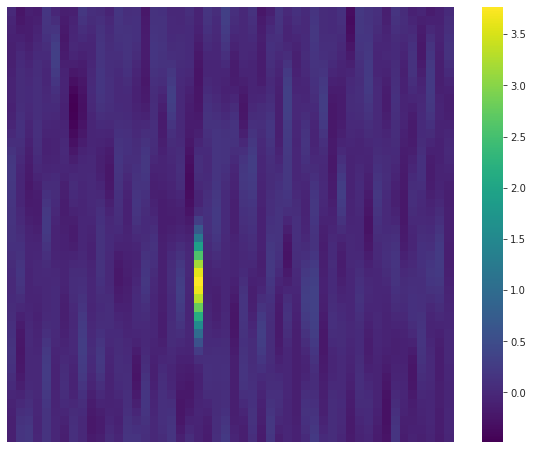

In [29]:
with sns.axes_style("white"):

    plt.figure(figsize=(10,8))
    ax = sns.heatmap(samples['f_pred'].mean(0).reshape(nd, nd), cmap='viridis',alpha=1)
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xticklabels([])

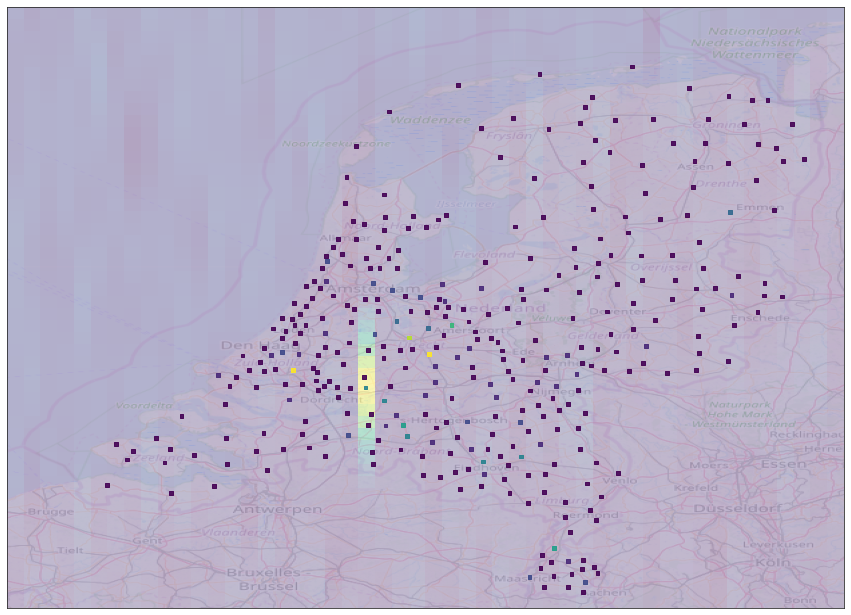

In [30]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(figsize = (15,15))
    ax.scatter(dfNL.Lon, dfNL.Lat, zorder=1, alpha= 0.9, c=dfNL.Aantal, s=15, marker='s',cmap=plt.cm.viridis)
#     ax2 = sns.heatmap(samples['f_pred'].mean(0).reshape(nd, nd), cmap='viridis',alpha=1)
#     sns.heatmap(samples['f_pred'].mean(0).reshape(nd, nd), cmap='viridis',alpha=1)
    ax.imshow(samples['f_pred'].mean(0).reshape(nd, nd),extent=BBox, origin='lower',cmap='viridis',alpha=.4)
#     ax.invert_yaxis()
#     ax.set_title('Plotting Spatial Data on Riyadh Map')
    ax.set_xlim(BBox[0],BBox[1])
    ax.set_ylim(BBox[2],BBox[3])
    nlMap = plt.imread('figures/mapNetherlands.png')
    ax.imshow(nlMap, zorder=0, extent = BBox, aspect= 'equal',alpha=.2)
    ax.set_yticklabels([])
    ax.set_xticklabels([])

-----------------------------

In [31]:


# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = '/downloads/DEU/DEU_adm1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())

ax = plt.axes(projection=ccrs.PlateCarree())

plt.title('Deutschland')
ax.coastlines(resolution='10m')

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(),
                  edgecolor='black', facecolor='gray', alpha=0.5)

ax.set_extent([4, 16, 47, 56], ccrs.PlateCarree())

plt.show()

NameError: name 'shpreader' is not defined